Funciones disponibles en los datos: ['NAN' '03: PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA'
 '10: AGRICULTURA' '23: PROTECCION SOCIAL' '22: EDUCACION' '20: SALUD'
 '15: TRANSPORTE' '19: VIVIENDA' '08: COMERCIO' '16: COMUNICACIONES'
 '17: AMBIENTE' '18: SANEAMIENTO' '24: PREVISION SOCIAL'
 '05: ORDEN PUBLICO Y SEGURIDAD' '21: CULTURA Y DEPORTE'
 '25: DEUDA PUBLICA' '11: PESCA' '12: ENERGIA' '07: TRABAJO' '09: TURISMO'
 '14: INDUSTRIA']


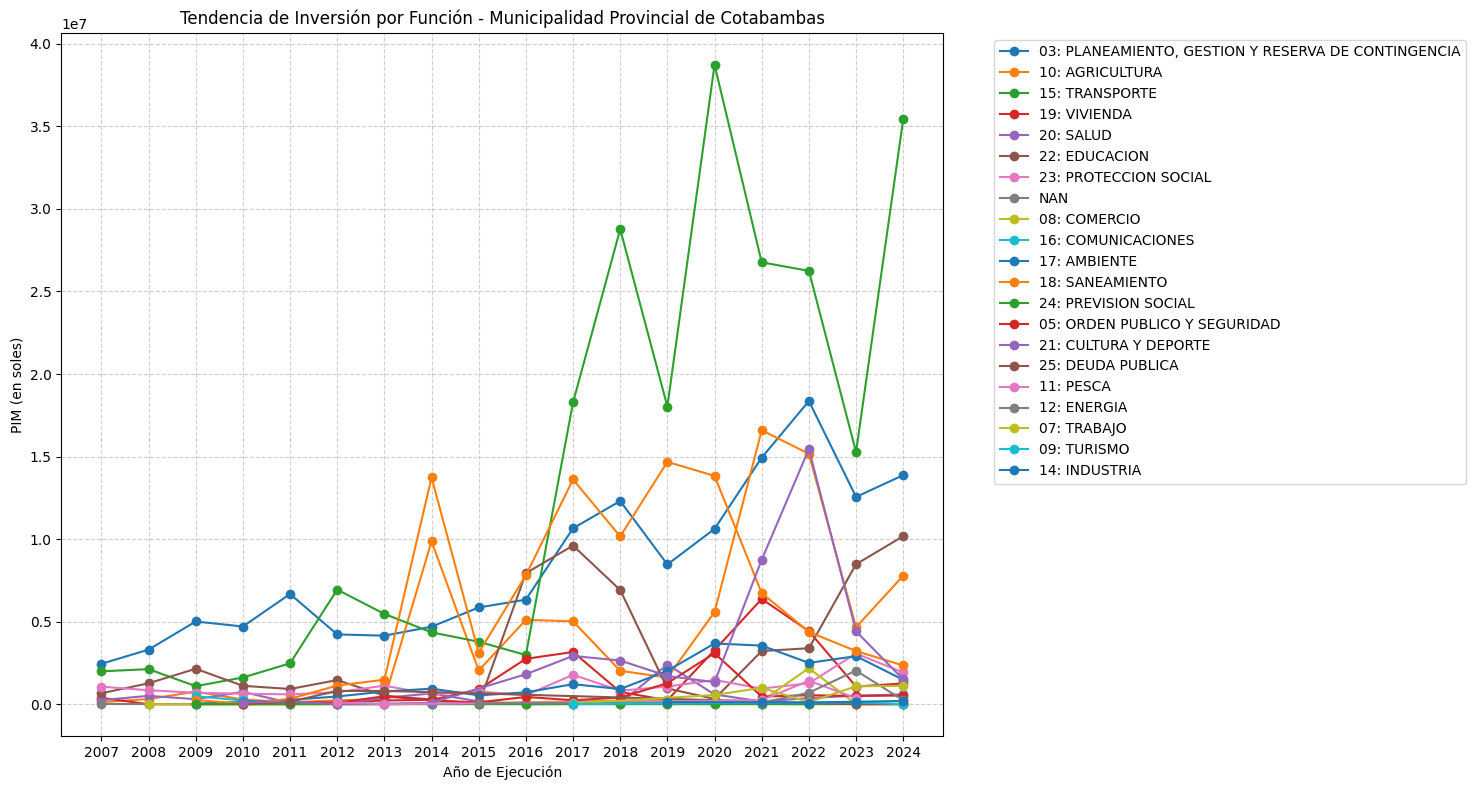

⚠ No hay datos suficientes para la función 'EDUCACION'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import os

# --- Function to load each file dynamically ---
def load_file(file_path):
    # Read raw without headers
    raw_df = pd.read_excel(file_path, header=None)
    
    # Find the row containing "Funcion" or "Función"
    header_row_idx = raw_df[raw_df.apply(
        lambda row: row.astype(str).str.contains("Funcion", case=False, regex=False).any(), 
        axis=1
    )].index[0]
    
    # Read again with the correct header
    df = pd.read_excel(file_path, skiprows=header_row_idx)
    return df

# --- 1. Load all years ---
dfs = {}
base_folder = "SMPCT_{year}/MPCT_FUNCION_{year}.xlsx"
years = range(2007, 2025)

for year in years:
    file_path = base_folder.format(year=year)
    if os.path.exists(file_path):
        try:
            df = load_file(file_path)
            df["Year"] = year
            dfs[str(year)] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"Error: {file_path} not found.")

if not dfs:
    raise FileNotFoundError("No files loaded. Please check paths.")

# --- 2. Combine all data ---
df_all = pd.concat(dfs.values(), ignore_index=True)

# --- 3. Clean column names ---
df_all.columns = [str(col).replace('.', '').strip() for col in df_all.columns]

# Map "Función" and "PIM" column variations to standard names
for col in df_all.columns:
    if col.lower().startswith("funcion"):
        df_all.rename(columns={col: "Función"}, inplace=True)
    elif col.lower().startswith("pim"):
        df_all.rename(columns={col: "PIM"}, inplace=True)

# --- 4. Clean and standardize function names ---
df_all['Función'] = df_all['Función'].astype(str).str.upper().str.strip()
df_all['Función'] = df_all['Función'].str.replace('ADMINISTRACION Y PLANEAMIENTO', 'PLANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACION Y CULTURA', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCION Y PREVISION SOCIAL', 'PROTECCION SOCIAL', regex=False)
df_all['Función'] = df_all['Función'].str.replace('SALUD Y SANEAMIENTO', 'SANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('VIVIENDA Y DESARROLLO URBANO', 'VIVIENDA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGRARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGROPECUARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACIÓN', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PLANEAMIENTO, GESTIÓN Y RESERVA DE CONTINGENCIA', 'PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCIÓN SOCIAL', 'PROTECCION SOCIAL', regex=False)

# --- 5. Convert PIM to numeric ---
df_all['PIM'] = pd.to_numeric(df_all['PIM'], errors='coerce')

# Debug: Check unique function names after cleaning
print("Funciones disponibles en los datos:", df_all['Función'].unique())

# --- 6. Visualization of trends ---
function_trends = df_all.groupby(['Year', 'Función'])['PIM'].sum().reset_index()

plt.figure(figsize=(15, 8))
for function in function_trends['Función'].unique():
    subset = function_trends[function_trends['Función'] == function]
    plt.plot(subset['Year'], subset['PIM'], label=function, marker='o')

plt.title('Tendencia de Inversión por Función - Municipalidad Provincial de Cotabambas')
plt.xlabel('Año de Ejecución')
plt.ylabel('PIM (en soles)')
plt.xticks(df_all['Year'].unique())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 7. ARIMA Forecast for Educación ---
df_educacion = df_all[df_all['Función'] == 'EDUCACION'].groupby('Year')['PIM'].sum().reset_index()

if not df_educacion.empty and df_educacion['Year'].notna().all():
    ts_educacion = pd.Series(df_educacion['PIM'].values, index=pd.to_datetime(df_educacion['Year'], format='%Y'))

    model = ARIMA(ts_educacion, order=(1, 1, 0))
    model_fit = model.fit()

    forecast_steps = 3
    forecast = model_fit.forecast(steps=forecast_steps)

    start_year = int(df_educacion['Year'].max()) + 1
    forecast_index = pd.date_range(start=str(start_year), periods=forecast_steps, freq='AS')
    forecast_series = pd.Series(forecast.values, index=forecast_index)

    plt.figure(figsize=(15, 8))
    plt.plot(ts_educacion, label='Datos Históricos de Inversión en Educación', marker='o')
    plt.plot(forecast_series, label=f'Pronóstico ({forecast_index[0].year}-{forecast_index[-1].year})',
             color='red', linestyle='--', marker='o')
    plt.title('Pronóstico de Inversión para la Función "Educación"')
    plt.xlabel('Año')
    plt.ylabel('PIM (en soles)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"\n--- Pronóstico para los próximos {forecast_steps} años ---")
    print(forecast_series)
else:
    print("⚠ No hay datos suficientes para la función 'EDUCACION'.")


Funciones disponibles en los datos: ['NAN' '03: PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA'
 '10: AGRICULTURA' '23: PROTECCION SOCIAL' '22: EDUCACION' '20: SALUD'
 '15: TRANSPORTE' '19: VIVIENDA' '08: COMERCIO' '16: COMUNICACIONES'
 '17: AMBIENTE' '18: SANEAMIENTO' '24: PREVISION SOCIAL'
 '05: ORDEN PUBLICO Y SEGURIDAD' '21: CULTURA Y DEPORTE'
 '25: DEUDA PUBLICA' '11: PESCA' '12: ENERGIA' '07: TRABAJO' '09: TURISMO'
 '14: INDUSTRIA']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23116\1917677090.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))


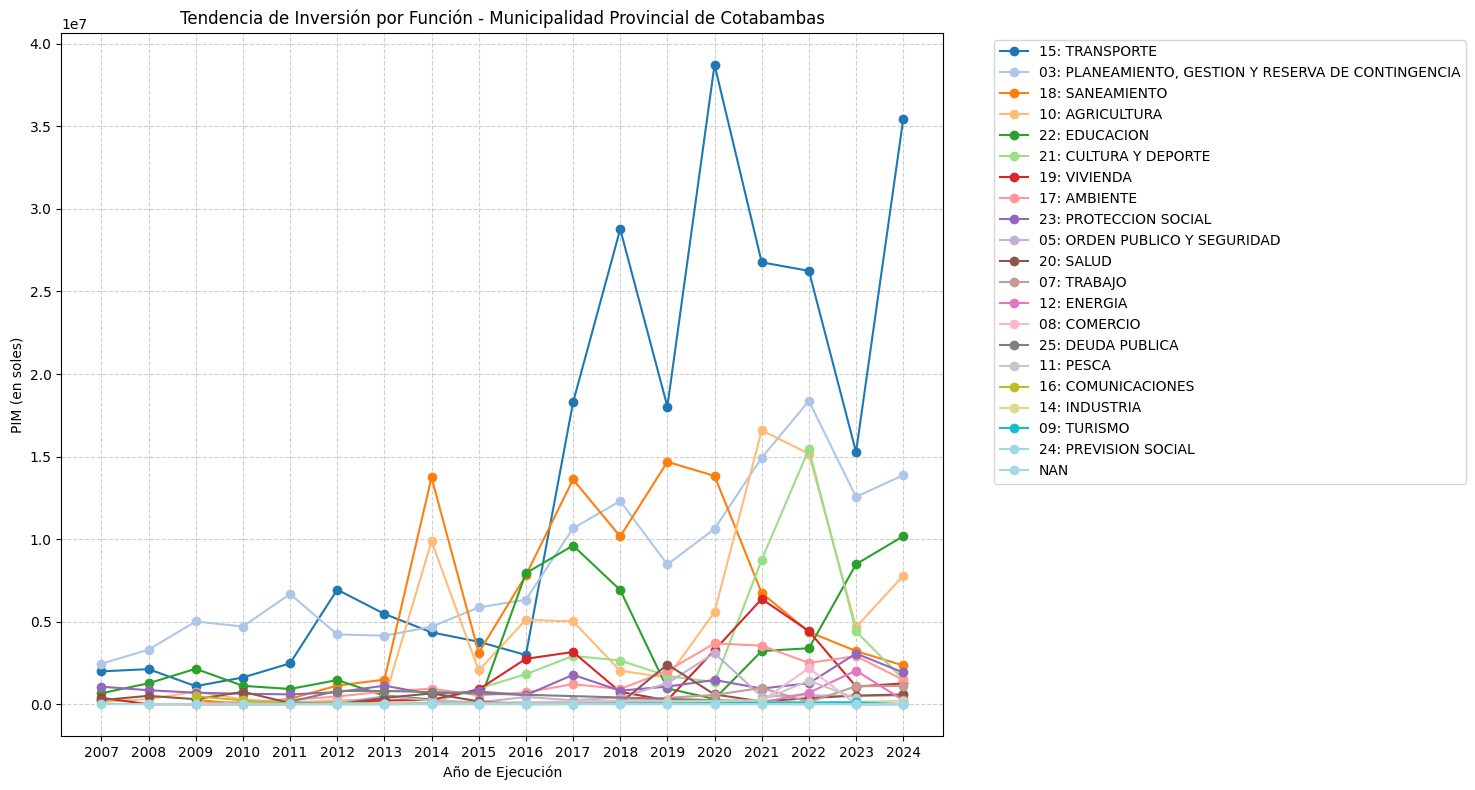

⚠ No hay datos suficientes para la función 'EDUCACION'.


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import os

# --- Function to load each file dynamically ---
def load_file(file_path):
    # Read raw without headers
    raw_df = pd.read_excel(file_path, header=None)
    
    # Find the row containing "Funcion" or "Función"
    header_row_idx = raw_df[raw_df.apply(
        lambda row: row.astype(str).str.contains("Funcion", case=False, regex=False).any(), 
        axis=1
    )].index[0]
    
    # Read again with the correct header
    df = pd.read_excel(file_path, skiprows=header_row_idx)
    return df

# --- 1. Load all years ---
dfs = {}
base_folder = "SMPCT_{year}/MPCT_FUNCION_{year}.xlsx"
years = range(2007, 2025)

for year in years:
    file_path = base_folder.format(year=year)
    if os.path.exists(file_path):
        try:
            df = load_file(file_path)
            df["Year"] = year
            dfs[str(year)] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"Error: {file_path} not found.")

if not dfs:
    raise FileNotFoundError("No files loaded. Please check paths.")

# --- 2. Combine all data ---
df_all = pd.concat(dfs.values(), ignore_index=True)

# --- 3. Clean column names ---
df_all.columns = [str(col).replace('.', '').strip() for col in df_all.columns]

# Map "Función" and "PIM" column variations to standard names
for col in df_all.columns:
    if col.lower().startswith("funcion"):
        df_all.rename(columns={col: "Función"}, inplace=True)
    elif col.lower().startswith("pim"):
        df_all.rename(columns={col: "PIM"}, inplace=True)

# --- 4. Clean and standardize function names ---
df_all['Función'] = df_all['Función'].astype(str).str.upper().str.strip()
df_all['Función'] = df_all['Función'].str.replace('ADMINISTRACION Y PLANEAMIENTO', 'PLANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACION Y CULTURA', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCION Y PREVISION SOCIAL', 'PROTECCION SOCIAL', regex=False)
df_all['Función'] = df_all['Función'].str.replace('SALUD Y SANEAMIENTO', 'SANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('VIVIENDA Y DESARROLLO URBANO', 'VIVIENDA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGRARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGROPECUARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACIÓN', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PLANEAMIENTO, GESTIÓN Y RESERVA DE CONTINGENCIA', 'PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCIÓN SOCIAL', 'PROTECCION SOCIAL', regex=False)

# --- 5. Convert PIM to numeric ---
df_all['PIM'] = pd.to_numeric(df_all['PIM'], errors='coerce')

# Debug: Check unique function names after cleaning
print("Funciones disponibles en los datos:", df_all['Función'].unique())

# --- 6. Visualization of trends (sorted + different colors) ---
function_trends = df_all.groupby(['Year', 'Función'])['PIM'].sum().reset_index()

# Order functions by total PIM (descending)
total_pim_by_function = function_trends.groupby('Función')['PIM'].sum().sort_values(ascending=False)
sorted_functions = total_pim_by_function.index.tolist()

# Generate a color map with as many distinct colors as functions
colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))

plt.figure(figsize=(15, 8))

for i, function in enumerate(sorted_functions):
    subset = function_trends[function_trends['Función'] == function]
    plt.plot(subset['Year'], subset['PIM'],
             label=function,
             marker='o',
             color=colors[i])

plt.title('Tendencia de Inversión por Función - Municipalidad Provincial de Cotabambas')
plt.xlabel('Año de Ejecución')
plt.ylabel('PIM (en soles)')
plt.xticks(sorted(df_all['Year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 7. ARIMA Forecast for Educación ---
df_educacion = df_all[df_all['Función'] == 'EDUCACION'].groupby('Year')['PIM'].sum().reset_index()

if not df_educacion.empty and df_educacion['Year'].notna().all():
    ts_educacion = pd.Series(df_educacion['PIM'].values, index=pd.to_datetime(df_educacion['Year'], format='%Y'))

    model = ARIMA(ts_educacion, order=(1, 1, 0))
    model_fit = model.fit()

    forecast_steps = 3
    forecast = model_fit.forecast(steps=forecast_steps)

    start_year = int(df_educacion['Year'].max()) + 1
    forecast_index = pd.date_range(start=str(start_year), periods=forecast_steps, freq='AS')
    forecast_series = pd.Series(forecast.values, index=forecast_index)

    plt.figure(figsize=(15, 8))
    plt.plot(ts_educacion, label='Datos Históricos de Inversión en Educación', marker='o')
    plt.plot(forecast_series, label=f'Pronóstico ({forecast_index[0].year}-{forecast_index[-1].year})',
             color='red', linestyle='--', marker='o')
    plt.title('Pronóstico de Inversión para la Función "Educación"')
    plt.xlabel('Año')
    plt.ylabel('PIM (en soles)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"\n--- Pronóstico para los próximos {forecast_steps} años ---")
    print(forecast_series)
else:
    print("⚠ No hay datos suficientes para la función 'EDUCACION'.")


Funciones incluidas (Avance % >= 90): ['10: AGRICULTURA' '23: PROTECCION SOCIAL' '22: EDUCACION' '20: SALUD'
 '15: TRANSPORTE' '17: AMBIENTE' '18: SANEAMIENTO' '24: PREVISION SOCIAL'
 '05: ORDEN PUBLICO Y SEGURIDAD' '16: COMUNICACIONES'
 '21: CULTURA Y DEPORTE' '11: PESCA' '25: DEUDA PUBLICA'
 '03: PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA' '19: VIVIENDA'
 '07: TRABAJO' '09: TURISMO' '08: COMERCIO' '14: INDUSTRIA']
Filas después del filtro: 131


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23116\3973141576.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))


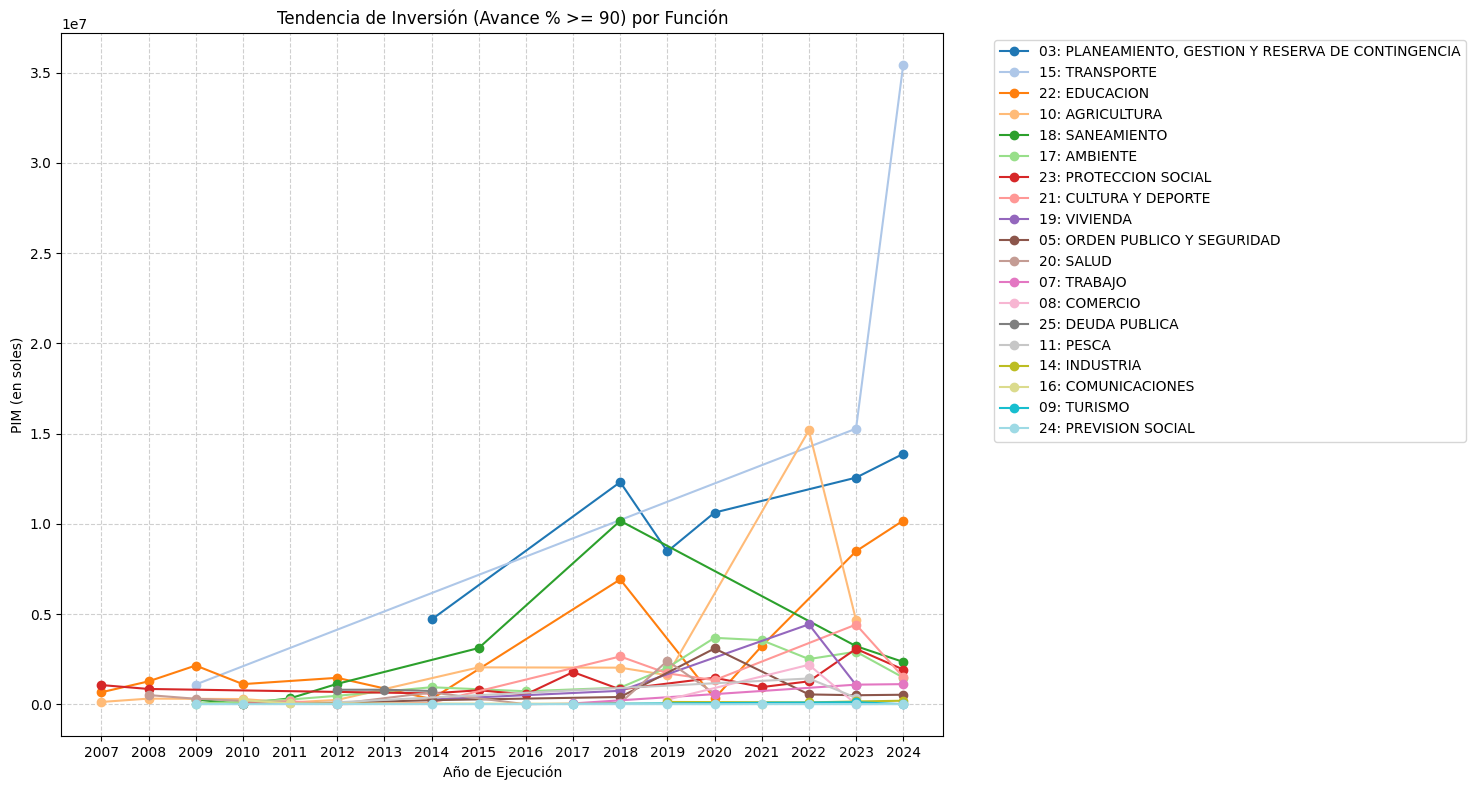

⚠ No hay datos suficientes para la función 'EDUCACION' con Avance % >= 90.


In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# --- Function to load each file dynamically ---
def load_file(file_path):
    # Read raw without headers
    raw_df = pd.read_excel(file_path, header=None)
    
    # Find the row containing "Funcion" or "Función"
    header_row_idx = raw_df[raw_df.apply(
        lambda row: row.astype(str).str.contains("Funcion", case=False, regex=False).any(), 
        axis=1
    )].index[0]
    
    # Read again with the correct header
    df = pd.read_excel(file_path, skiprows=header_row_idx)
    return df

# --- 1. Load all years ---
dfs = {}
base_folder = "SMPCT_{year}/MPCT_FUNCION_{year}.xlsx"
years = range(2007, 2025)

for year in years:
    file_path = base_folder.format(year=year)
    if os.path.exists(file_path):
        try:
            df = load_file(file_path)
            df["Year"] = year
            dfs[str(year)] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"Error: {file_path} not found.")

if not dfs:
    raise FileNotFoundError("No files loaded. Please check paths.")

# --- 2. Combine all data ---
df_all = pd.concat(dfs.values(), ignore_index=True)

# --- 3. Clean column names ---
df_all.columns = [str(col).replace('.', '').strip() for col in df_all.columns]

# Map "Función", "PIM", and "Avance %" column variations to standard names
for col in df_all.columns:
    if col.lower().startswith("funcion"):
        df_all.rename(columns={col: "Función"}, inplace=True)
    elif col.lower().startswith("pim"):
        df_all.rename(columns={col: "PIM"}, inplace=True)
    elif "avance" in col.lower():
        df_all.rename(columns={col: "Avance %"}, inplace=True)

# --- 4. Clean and standardize function names ---
df_all['Función'] = df_all['Función'].astype(str).str.upper().str.strip()
df_all['Función'] = df_all['Función'].str.replace('ADMINISTRACION Y PLANEAMIENTO', 'PLANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACION Y CULTURA', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCION Y PREVISION SOCIAL', 'PROTECCION SOCIAL', regex=False)
df_all['Función'] = df_all['Función'].str.replace('SALUD Y SANEAMIENTO', 'SANEAMIENTO', regex=False)
df_all['Función'] = df_all['Función'].str.replace('VIVIENDA Y DESARROLLO URBANO', 'VIVIENDA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGRARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('AGROPECUARIA', 'AGRICULTURA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('EDUCACIÓN', 'EDUCACION', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PLANEAMIENTO, GESTIÓN Y RESERVA DE CONTINGENCIA', 'PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA', regex=False)
df_all['Función'] = df_all['Función'].str.replace('PROTECCIÓN SOCIAL', 'PROTECCION SOCIAL', regex=False)

# --- 5. Convert PIM to numeric ---
df_all['PIM'] = pd.to_numeric(df_all['PIM'], errors='coerce')

# --- 6. Clean "Avance %" column ---
if "Avance %" in df_all.columns:
    df_all['Avance %'] = (
        df_all['Avance %']
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)  # convert comma decimals to dot
        .str.strip()
    )
    df_all['Avance %'] = pd.to_numeric(df_all['Avance %'], errors='coerce')
else:
    raise ValueError("No 'Avance %' column found after renaming.")

# --- 7. Filter only where Avance % >= 90 ---
df_all = df_all[df_all['Avance %'] >= 90.0]

# Debug: check
print("Funciones incluidas (Avance % >= 90):", df_all['Función'].unique())
print("Filas después del filtro:", len(df_all))

# --- 8. Visualization of trends (sorted + different colors) ---
function_trends = df_all.groupby(['Year', 'Función'])['PIM'].sum().reset_index()

# Order functions by total PIM (descending)
total_pim_by_function = function_trends.groupby('Función')['PIM'].sum().sort_values(ascending=False)
sorted_functions = total_pim_by_function.index.tolist()

# Generate a color map with as many distinct colors as functions
colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))

plt.figure(figsize=(15, 8))

for i, function in enumerate(sorted_functions):
    subset = function_trends[function_trends['Función'] == function]
    plt.plot(subset['Year'], subset['PIM'],
             label=function,
             marker='o',
             color=colors[i])

plt.title('Tendencia de Inversión (Avance % >= 90) por Función')
plt.xlabel('Año de Ejecución')
plt.ylabel('PIM (en soles)')
plt.xticks(sorted(df_all['Year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 9. Regression Forecast for Educación ---
df_educacion = df_all[df_all['Función'] == 'EDUCACION'].groupby('Year')['PIM'].sum().reset_index()

if not df_educacion.empty and df_educacion['Year'].notna().all():
    X = df_educacion[['Year']].values
    y = df_educacion['PIM'].values

    model = LinearRegression()
    model.fit(X, y)

    forecast_steps = 3
    last_year = int(df_educacion['Year'].max())
    future_years = np.arange(last_year + 1, last_year + forecast_steps + 1).reshape(-1, 1)
    forecast = model.predict(future_years)

    plt.figure(figsize=(15, 8))
    plt.plot(df_educacion['Year'], df_educacion['PIM'], label='Datos Históricos (Educación)', marker='o')
    plt.plot(future_years.flatten(), forecast, label='Pronóstico (Regresión Lineal)', linestyle='--', marker='o', color='red')
    plt.title('Pronóstico de Inversión para la Función "Educación" (Avance % >= 90)')
    plt.xlabel('Año')
    plt.ylabel('PIM (en soles)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("\n--- Pronóstico (Regresión Lineal) para los próximos años ---")
    for year, value in zip(future_years.flatten(), forecast):
        print(f"{year}: {value:,.2f}")
else:
    print("⚠ No hay datos suficientes para la función 'EDUCACION' con Avance % >= 90.")


Funciones incluidas (Avance % >= 90): ['10: AGRICULTURA' '23: PROTECCION SOCIAL' '22: EDUCACION' '20: SALUD'
 '15: TRANSPORTE' '17: AMBIENTE' '18: SANEAMIENTO' '24: PREVISION SOCIAL'
 '05: ORDEN PUBLICO Y SEGURIDAD' '16: COMUNICACIONES'
 '21: CULTURA Y DEPORTE' '11: PESCA' '25: DEUDA PUBLICA'
 '03: PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA' '19: VIVIENDA'
 '07: TRABAJO' '09: TURISMO' '08: COMERCIO' '14: INDUSTRIA']
Filas después del filtro: 131


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23116\743364098.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))


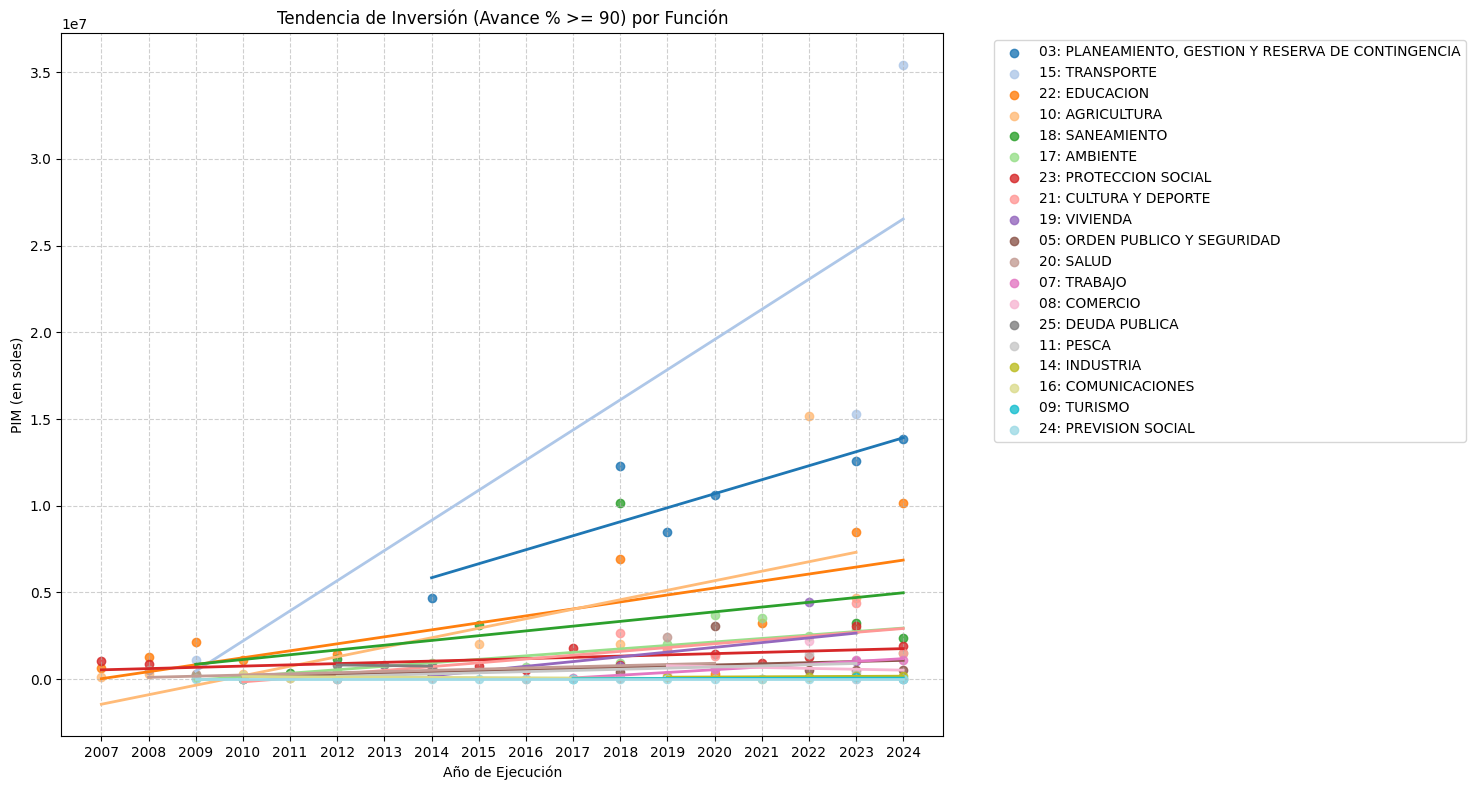

⚠ No hay datos suficientes para la función 'EDUCACION' con Avance % >= 90.


In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# --- Function to load each file dynamically ---
def load_file(file_path):
    raw_df = pd.read_excel(file_path, header=None)
    header_row_idx = raw_df[raw_df.apply(
        lambda row: row.astype(str).str.contains("Funcion", case=False, regex=False).any(), 
        axis=1
    )].index[0]
    df = pd.read_excel(file_path, skiprows=header_row_idx)
    return df

# --- 1. Load all years ---
dfs = {}
base_folder = "SMPCT_{year}/MPCT_FUNCION_{year}.xlsx"
years = range(2007, 2025)

for year in years:
    file_path = base_folder.format(year=year)
    if os.path.exists(file_path):
        try:
            df = load_file(file_path)
            df["Year"] = year
            dfs[str(year)] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"Error: {file_path} not found.")

if not dfs:
    raise FileNotFoundError("No files loaded. Please check paths.")

# --- 2. Combine ---
df_all = pd.concat(dfs.values(), ignore_index=True)

# --- 3. Clean column names ---
df_all.columns = [str(col).replace('.', '').strip() for col in df_all.columns]
for col in df_all.columns:
    if col.lower().startswith("funcion"):
        df_all.rename(columns={col: "Función"}, inplace=True)
    elif col.lower().startswith("pim"):
        df_all.rename(columns={col: "PIM"}, inplace=True)
    elif "avance" in col.lower():
        df_all.rename(columns={col: "Avance %"}, inplace=True)

# --- 4. Standardize names ---
df_all['Función'] = df_all['Función'].astype(str).str.upper().str.strip()
replacements = {
    'ADMINISTRACION Y PLANEAMIENTO': 'PLANEAMIENTO',
    'EDUCACION Y CULTURA': 'EDUCACION',
    'PROTECCION Y PREVISION SOCIAL': 'PROTECCION SOCIAL',
    'SALUD Y SANEAMIENTO': 'SANEAMIENTO',
    'VIVIENDA Y DESARROLLO URBANO': 'VIVIENDA',
    'AGRARIA': 'AGRICULTURA',
    'AGROPECUARIA': 'AGRICULTURA',
    'EDUCACIÓN': 'EDUCACION',
    'PLANEAMIENTO, GESTIÓN Y RESERVA DE CONTINGENCIA': 'PLANEAMIENTO, GESTION Y RESERVA DE CONTINGENCIA',
    'PROTECCIÓN SOCIAL': 'PROTECCION SOCIAL'
}
for old, new in replacements.items():
    df_all['Función'] = df_all['Función'].str.replace(old, new, regex=False)

# --- 5. Convert to numeric ---
df_all['PIM'] = pd.to_numeric(df_all['PIM'], errors='coerce')

# --- 6. Clean "Avance %" ---
if "Avance %" in df_all.columns:
    df_all['Avance %'] = (
        df_all['Avance %'].astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .str.strip()
    )
    df_all['Avance %'] = pd.to_numeric(df_all['Avance %'], errors='coerce')
else:
    raise ValueError("No 'Avance %' column found after renaming.")

# --- 7. Filter ---
df_all = df_all[df_all['Avance %'] >= 90.0]

print("Funciones incluidas (Avance % >= 90):", df_all['Función'].unique())
print("Filas después del filtro:", len(df_all))

# --- 8. Visualization with distinct colors + regression lines ---
function_trends = df_all.groupby(['Year', 'Función'])['PIM'].sum().reset_index()
total_pim_by_function = function_trends.groupby('Función')['PIM'].sum().sort_values(ascending=False)
sorted_functions = total_pim_by_function.index.tolist()
colors = cm.get_cmap('tab20', len(sorted_functions))(np.arange(len(sorted_functions)))

plt.figure(figsize=(15, 8))

for i, function in enumerate(sorted_functions):
    subset = function_trends[function_trends['Función'] == function]
    
    # Scatter points
    plt.scatter(subset['Year'], subset['PIM'], label=function, color=colors[i], alpha=0.8)
    
    # Regression line
    if len(subset) > 1:
        X = subset['Year'].values.reshape(-1, 1)
        y = subset['PIM'].values
        model = LinearRegression().fit(X, y)
        X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_fit = model.predict(X_fit)
        plt.plot(X_fit, y_fit, color=colors[i], linewidth=2)

plt.title('Tendencia de Inversión (Avance % >= 90) por Función')
plt.xlabel('Año de Ejecución')
plt.ylabel('PIM (en soles)')
plt.xticks(sorted(df_all['Year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 9. Regression Forecast for Educación ---
df_educacion = df_all[df_all['Función'] == 'EDUCACION'].groupby('Year')['PIM'].sum().reset_index()

if not df_educacion.empty and df_educacion['Year'].notna().all():
    X = df_educacion[['Year']].values
    y = df_educacion['PIM'].values
    model = LinearRegression().fit(X, y)

    forecast_steps = 3
    last_year = int(df_educacion['Year'].max())
    future_years = np.arange(last_year + 1, last_year + forecast_steps + 1).reshape(-1, 1)
    forecast = model.predict(future_years)

    plt.figure(figsize=(15, 8))
    plt.scatter(df_educacion['Year'], df_educacion['PIM'], label='Datos Históricos (Educación)', color='blue')
    plt.plot(df_educacion['Year'], df_educacion['PIM'], color='blue')
    plt.plot(future_years.flatten(), forecast, label='Pronóstico (Regresión Lineal)', linestyle='--', marker='o', color='red')
    plt.title('Pronóstico de Inversión para la Función "Educación" (Avance % >= 90)')
    plt.xlabel('Año')
    plt.ylabel('PIM (en soles)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("\n--- Pronóstico (Regresión Lineal) para los próximos años ---")
    for year, value in zip(future_years.flatten(), forecast):
        print(f"{year}: {value:,.2f}")
else:
    print("⚠ No hay datos suficientes para la función 'EDUCACION' con Avance % >= 90.")
